## Lab Assignment 3

> Jaskirat SIngh Maskeen

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from radon.raw import analyze
from radon.complexity import cc_visit
from radon.metrics import mi_visit
import warnings
import sacrebleu
from sacrebleu.metrics import BLEU
import re
import torch.nn.functional as F
import torch
from transformers import AutoTokenizer, AutoModel
warnings.filterwarnings("ignore")

c:\Users\GSRAJA\Desktop\IIT GN\sem5\sttcse\Labs\STT_Lab_3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing Lab 2 Dataset

In [5]:
modified_files_dataset = pd.read_csv('Lab2_Files/rectified_messages.csv')

### Computing baseline descriptive statistics

In [3]:
total_commits = len(modified_files_dataset['hash'].unique())
print(total_commits)

1402


In [108]:
total_files = len(modified_files_dataset['filename'].unique())
print(total_files)

146


In [4]:
average_files_per_commit = modified_files_dataset['hash'].value_counts().mean()
print(average_files_per_commit)

1.7154065620542083


To categorise the fix type, I just see the first word of LLM inference, as most often that is the `fix category` under which the commit lies

In [5]:
first_word_for_fix_type = modified_files_dataset['llm_inference'].str.lower().str.split().str[0].value_counts()
print(first_word_for_fix_type)

llm_inference
update        860
fix           565
add           509
remove        200
improve       129
use            93
set            13
simplify        4
return          3
upgrade         3
apply           2
rename          2
escape          2
send            2
ignore          2
pass            1
deprecate       1
support         1
call            1
poll            1
check           1
terminate       1
delete          1
disconnect      1
stop            1
raise           1
replace         1
handle          1
reset           1
convert         1
reorganize      1
Name: count, dtype: int64


In [ ]:
term_to_category = {
    "update": "update", "upgrade": "update", "improve": "update", "apply": "update", "set": "update",
    "use": "update", "simplify": "update", "replace": "update", "convert": "update", 
    "reorganize": "update", "fix": "fix", "escape": "fix", "ignore": "fix", "handle": "fix", 
    "reset": "fix", "add": "add", "support": "add", "call": "add", "poll": "add",
    "remove": "remove", "delete": "remove", "disconnect": "remove", "stop": "remove", 
    "terminate": "remove", "rename": "refactor", "return": "refactor", "pass": "refactor",
    "deprecate": "refactor", "send": "misc", "check": "misc", "raise": "misc"
    }

values = {k: 0 for k in set(term_to_category.values())}

In [7]:
for k,v in first_word_for_fix_type.items():
    values[term_to_category[k]]+= v

{'add': 512, 'remove': 204, 'refactor': 7, 'fix': 571, 'misc': 4, 'update': 1107}


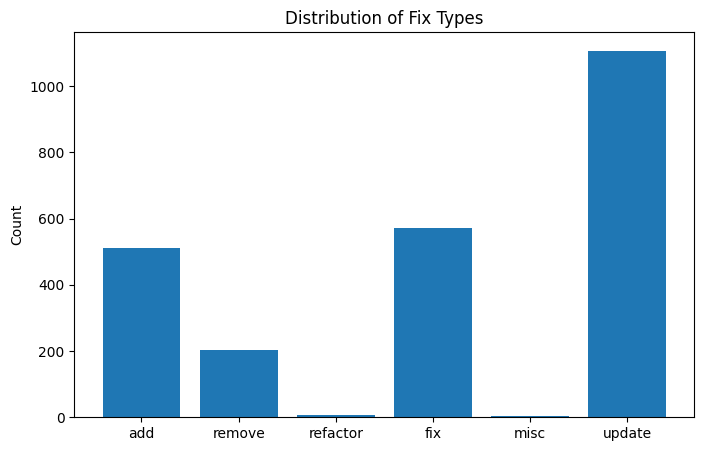

In [23]:
print(values)
plt.figure(figsize=(8,5))
plt.bar(values.keys(), values.values())

plt.ylabel("Count")
plt.title("Distribution of Fix Types")
plt.show()

In [110]:
ext_distribution = modified_files_dataset['filename'].astype(str).apply(lambda x: x.split('.')[-1]).value_counts()
print(ext_distribution)

filename
py         2050
rst         256
css          31
md           15
yml          12
txt          10
html          9
js            8
nan           6
po            5
in            1
LICENSE       1
inv           1
Name: count, dtype: int64


In [111]:
ext_distribution.values

array([2050,  256,   31,   15,   12,   10,    9,    8,    6,    5,    1,
          1,    1])

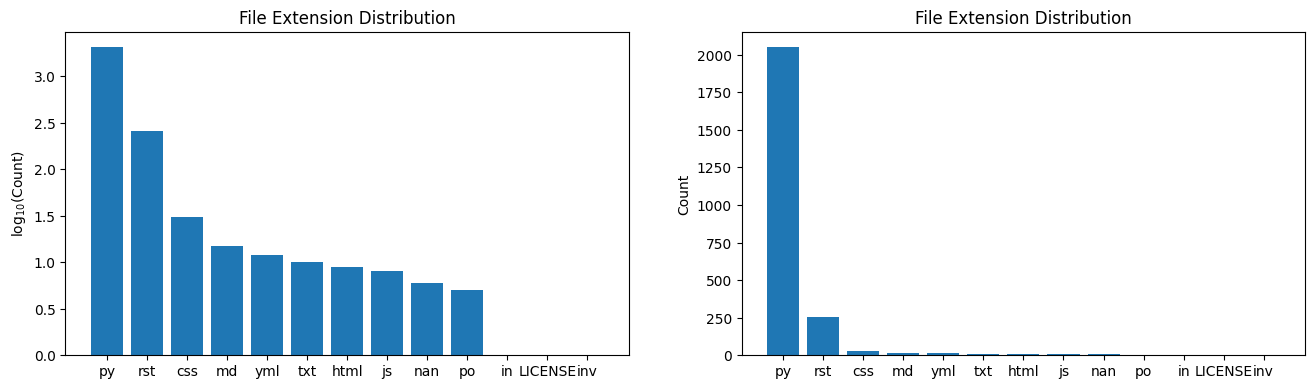

In [115]:
plt.figure(figsize=(16,4.2))
plt.subplot(1,2,1)
plt.bar(ext_distribution.keys(), np.log10(ext_distribution.values))

plt.ylabel("log$_{10}$(Count)")
plt.title("File Extension Distribution")
plt.subplot(1,2,2)
plt.bar(ext_distribution.keys(), ext_distribution.values)

plt.ylabel("Count")
plt.title("File Extension Distribution")
plt.show()

### Structural Metrics with `radon`

In [77]:
def radon_metrics(code):
    if isinstance(code,float):
        return 0,0,0
    try:
        raw = analyze(code)
        sloc = raw.sloc
        mi = mi_visit(code, True)
        cc_values = [r.complexity for r in cc_visit(code)]
        cc_total = int(sum(cc_values)) if cc_values else 0
    except SyntaxError:
        mi = 0
        cc_total = 0
        sloc = len(code.splitlines())
    return mi,cc_total,sloc

In [78]:
mi_change = []
cc_change = []
loc_change = []

In [79]:
for i in range(len(modified_files_dataset)):
    print(f'Cuurently at file {i+1}/{len(modified_files_dataset)}\r',end='')
    mi_bef,cc_bef,loc_bef = radon_metrics(modified_files_dataset['source_code_before'][i])
    mi_aft,cc_aft,loc_aft = radon_metrics(modified_files_dataset['source_code_current'][i])
    mi_change.append(mi_aft - mi_bef)
    cc_change.append(cc_aft - cc_bef)
    loc_change.append(loc_aft - loc_bef)
modified_files_dataset['mi_change'] = mi_change
modified_files_dataset['cc_change'] = cc_change
modified_files_dataset['loc_change'] = loc_change
    

### Change Magnitude Metrics

#### Using CodeBERT (Semantic Similarity)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
# model = RobertaModel.from_pretrained("microsoft/codebert-base")
tokenizer = AutoTokenizer.from_pretrained("model")
model = AutoModel.from_pretrained("model")
model.to(device)
model.eval()
print()
batch_size = 32

cuda



In [14]:
def generate_embeddings(code_ls):
    inputs = tokenizer(
        code_ls,
        padding=True,
        truncation=True,
        max_length=512, 
        return_tensors="pt"
    ).to(device) 

    with torch.no_grad(): 
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return embeddings

In [15]:
before_code_list = modified_files_dataset['source_code_before'].tolist()
current_code_list = modified_files_dataset['source_code_current'].tolist()

In [16]:
for i in range(len(before_code_list)):
    if isinstance(before_code_list[i],float):
        before_code_list[i] = ''
for i in range(len(current_code_list)):
    if isinstance(current_code_list[i],float):
        current_code_list[i] = ''

In [17]:
all_similarities = []

In [18]:
for i in range(0, len(before_code_list), batch_size):
    batch_before = before_code_list[i : i + batch_size]
    batch_current = current_code_list[i : i + batch_size]

    embeddings_before = generate_embeddings(batch_before)
    embeddings_current = generate_embeddings(batch_current)

    bert_cos_similarity = F.cosine_similarity(embeddings_before, embeddings_current)
    all_similarities.extend(bert_cos_similarity.cpu().numpy())

In [19]:
modified_files_dataset['bert_before_after_code_cossim'] = all_similarities

#### Using BLEU (Token Similarity)

In [31]:
def compute_bleu(row):
    if pd.isna(row['source_code_before']) or pd.isna(row['source_code_current']):
        return np.nan
    before_ls = [row['source_code_before']]
    after = row['source_code_current']
    return sacrebleu.sentence_bleu(after, before_ls).score

In [32]:
modified_files_dataset['sacre_bleu_token_similarity'] = modified_files_dataset.apply(compute_bleu, axis=1)

In [14]:
modified_files_dataset['sacre_bleu_token_similarity']/=100

In [ ]:
p4 = modified_files_dataset['sacre_bleu_token_similarity'].quantile(0.04)

print(f"4th Percentile: {p4:.2f}")

4th Percentile: 0.87


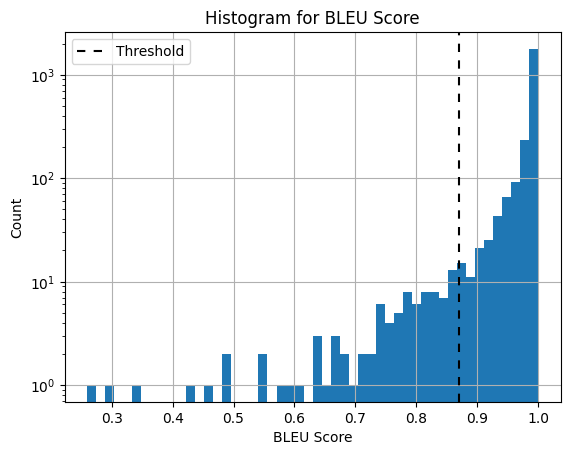

In [ ]:
modified_files_dataset['sacre_bleu_token_similarity'].hist(bins=50, log=True)
bleu_thresh = 0.87
plt.axvline(bleu_thresh,c='k',dashes=[4, 4],label='Threshold')
plt.legend()
plt.xlabel('BLEU Score')
plt.ylabel('Count')
plt.title('Histogram for BLEU Score')
plt.show()

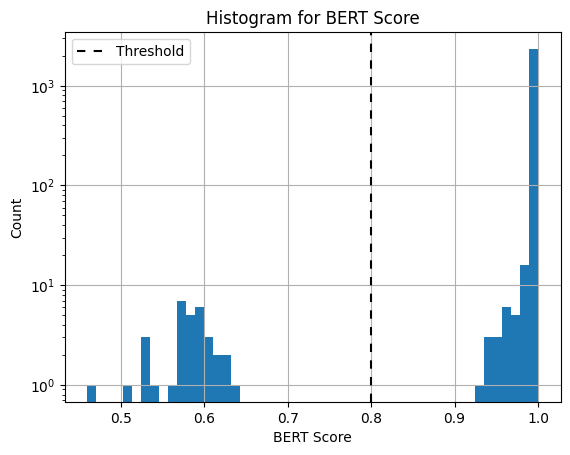

In [ ]:
modified_files_dataset['bert_before_after_code_cossim'].hist(bins=50, log=True)
bert_thresh = 0.8
plt.axvline(bert_thresh,c='k',dashes=[4, 4],label='Threshold')
plt.xlabel('BERT Score')
plt.ylabel('Count')
plt.title('Histogram for BERT Score')
plt.legend()
plt.show()

In [18]:
modified_files_dataset.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'hash', 'message', 'source_code_before',
       'source_code_current', 'diff', 'llm_inference', 'rectified_msg',
       'timestamp', 'bert_f1_pred', 'bert_f1_orig', 'cosine_pred',
       'cosine_orig', 'filename', 'mi_change', 'cc_change', 'loc_change',
       'bert_before_after_code_cossim', 'sacre_bleu_token_similarity'],
      dtype='object')

In [ ]:
modified_files_dataset['semantic_class'] = np.where(
    modified_files_dataset['bert_before_after_code_cossim'] < bert_thresh,
    'Major',
    'Minor'
)

modified_files_dataset['token_class'] = np.where(
    modified_files_dataset['sacre_bleu_token_similarity'] < bleu_thresh,
    'Major',
    'Minor'
)

In [20]:
modified_files_dataset.rename(columns={'bert_before_after_code_cossim': 'semantic_similarity','sacre_bleu_token_similarity':'token_similarity'}, inplace=True)

In [105]:
modified_files_dataset["classes_agree"] = np.where(
    modified_files_dataset["semantic_class"] == modified_files_dataset["token_class"],
    "YES",
    "NO",
)

In [22]:
for i in [
    "timestamp",
    "bert_f1_pred",
    "bert_f1_orig",
    "cosine_pred",
    "cosine_orig",
    "Unnamed: 0.1",
    "Unnamed: 0",
]:
    modified_files_dataset.drop(i, axis=1, inplace=True)

In [27]:
modified_files_dataset = pd.read_csv('bugfix_commits_multimetric_analysis.csv')

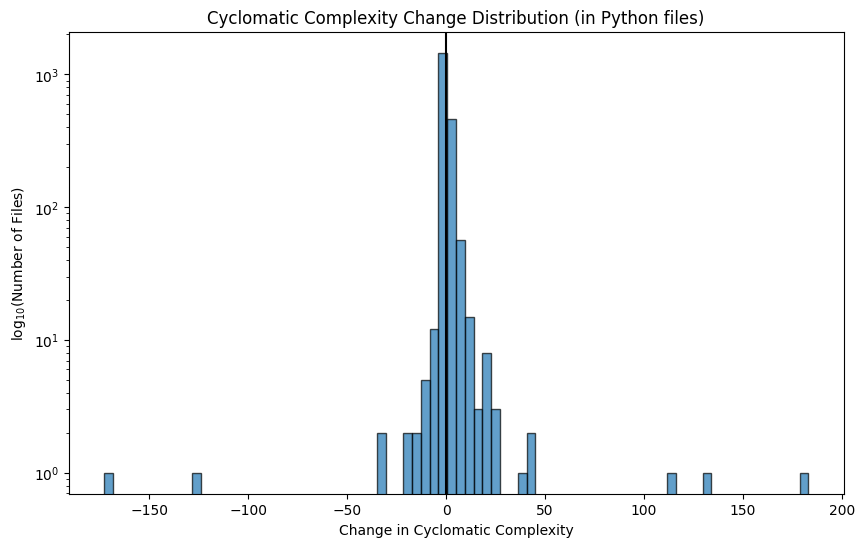

In [54]:
plt.figure(figsize=(10,6))

python_files_cc_change = modified_files_dataset.dropna()[modified_files_dataset.dropna()['filename'].str.endswith('.py')]['cc_change']

plt.hist(
    python_files_cc_change,
    bins=80,
    edgecolor='black',
    alpha=0.7,
    log = True
)
plt.axvline(color='k')
# plt.axvline(linestyle='--',color='k',x=np.mean(python_files_cc_change))
plt.title("Cyclomatic Complexity Change Distribution (in Python files)")
plt.xlabel("Change in Cyclomatic Complexity")
plt.ylabel("log$_{10}$(Number of Files)")
plt.show()


In [ ]:
np.mean(python_files_cc_change)

np.float64(0.7361179361179361)

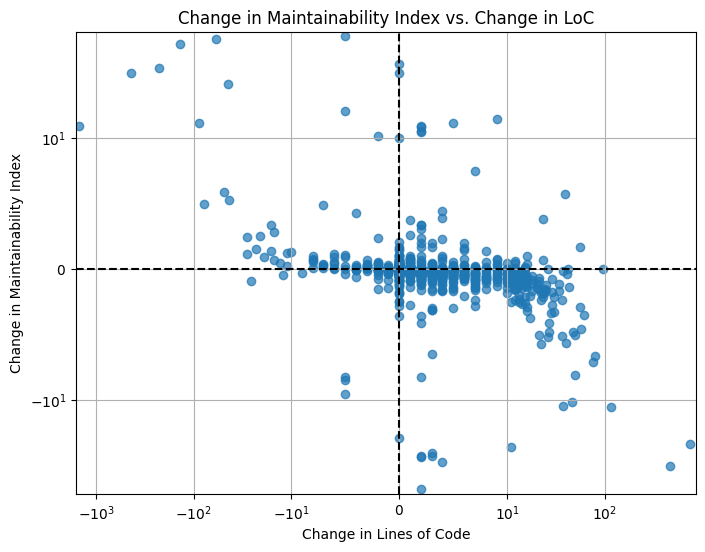

In [78]:
plt.figure(figsize=(8,6))
plt.scatter(modified_files_dataset.dropna()[modified_files_dataset.dropna()['filename'].str.endswith('.py')]['loc_change'], modified_files_dataset.dropna()[modified_files_dataset.dropna()['filename'].str.endswith('.py')]['mi_change'], alpha=0.7)

plt.title('Change in Maintainability Index vs. Change in LoC')
plt.xlabel('Change in Lines of Code')
plt.ylabel('Change in Maintainability Index')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xscale('symlog', linthresh=10)
plt.yscale('symlog', linthresh=10)
plt.grid(True)
plt.show()

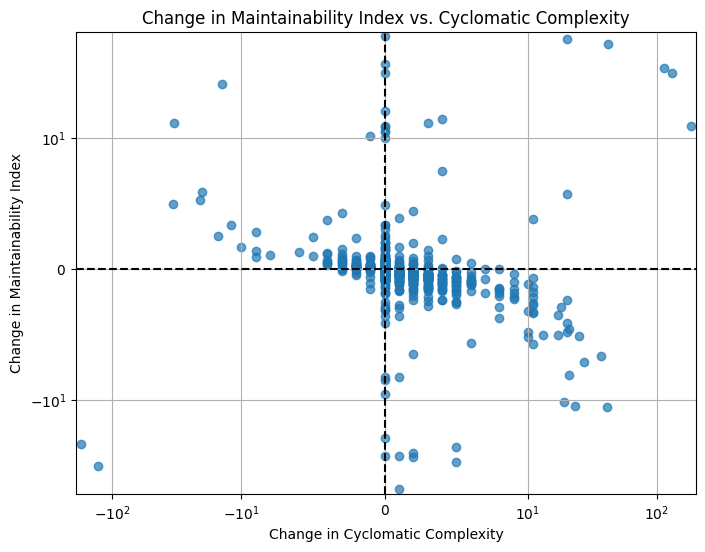

In [81]:
plt.figure(figsize=(8,6))
plt.scatter(modified_files_dataset.dropna()[modified_files_dataset.dropna()['filename'].str.endswith('.py')]['cc_change'], modified_files_dataset.dropna()[modified_files_dataset.dropna()['filename'].str.endswith('.py')]['mi_change'], alpha=0.7)

plt.title('Change in Maintainability Index vs. Cyclomatic Complexity')
plt.xlabel('Change in Cyclomatic Complexity')
plt.ylabel('Change in Maintainability Index')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xscale('symlog', linthresh=10)
plt.yscale('symlog', linthresh=10)
plt.grid(True)
plt.show()

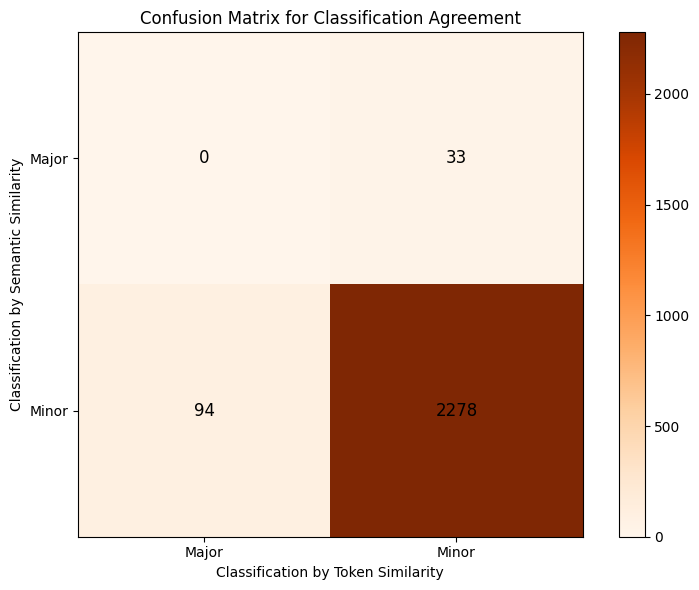

In [115]:
conf_matrix = pd.crosstab(modified_files_dataset['semantic_class'], modified_files_dataset['token_class'])

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap="Oranges", interpolation="nearest")
plt.colorbar()
classes_x = conf_matrix.columns
classes_y = conf_matrix.index
plt.xticks(np.arange(len(classes_x)), classes_x)
plt.yticks(np.arange(len(classes_y)), classes_y)

for i in range(len(classes_y)):
    for j in range(len(classes_x)):
        plt.text(j, i, conf_matrix.iloc[i, j],
                 ha="center", va="center", color="black", fontsize=12)

plt.title("Confusion Matrix for Classification Agreement")
plt.xlabel("Classification by Token Similarity")
plt.ylabel("Classification by Semantic Similarity")

plt.tight_layout()
plt.show()
